# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

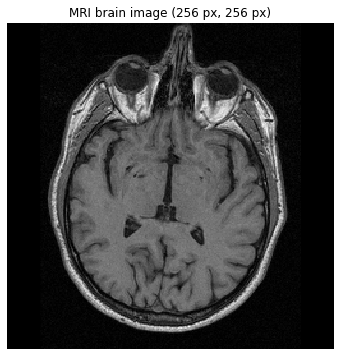

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [3]:
import cv2
import numpy as np

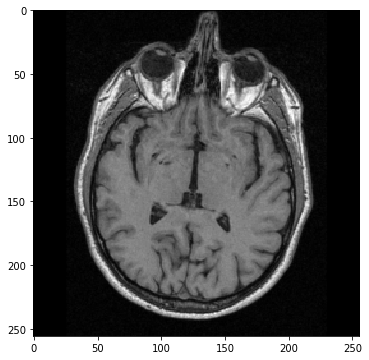

In [4]:
# Using Gaussian filter to denoise image
brain_denoise = cv2.GaussianBlur(brain_im,(5,5),0.5,0.5)
plt.figure(figsize=[6,6])
plt.imshow(brain_denoise,cmap='gray')

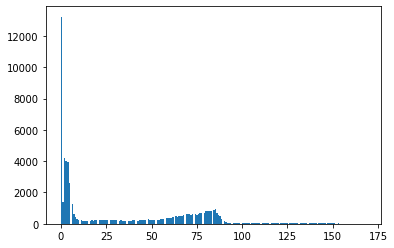

In [5]:
plt.hist(brain_denoise.ravel(),bins=200)
plt.show()

In [6]:
def region_growing(img, seed, threshold):

    img = np.float32(img)
    
    # 8-connected growing method
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),(-1,-1),(-1,1),(1,1),(1,-1)]
    region_size = 1
    neighbor_points_list = []
    neighbor_points_list.append(seed)
    
    #Initialize segmented output image
    height,width = img.shape
    segmented_img = np.zeros((height, width), np.uint8)
    
    while len(neighbor_points_list) != 0:  
        
        seed = neighbor_points_list.pop(0)
        for i in range(8):
            
            #Compute the neighbor pixel position
            x_new = seed[0] + neighbors[i][0]
            y_new = seed[1] + neighbors[i][1]
            
            checkout = (x_new >= 0) & (y_new >= 0) & (x_new < height) & (y_new < width)
            if checkout:
                if segmented_img[x_new, y_new] == 0:
                    
                    # compute difference
                    difference = np.abs(img[x_new,y_new]-img[seed[0],seed[1]])
                    
                    if difference <= threshold:
                        
                        neighbor_points_list.append([x_new,y_new])
                        segmented_img[x_new, y_new] = 255
                        region_size+=1
                        
    return segmented_img,region_size

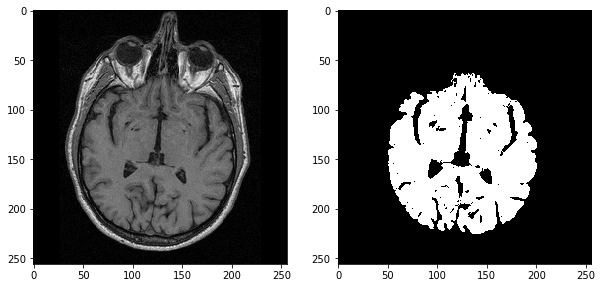

In [10]:
# set seed
seed = [153,82]
segmented_img, region_size = region_growing(brain_denoise, seed, 4)
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(brain_im, cmap='gray')
ax[1].imshow(segmented_img,cmap='gray')
plt.show()

In [13]:
print("The brain size is ",region_size)

The brain size is  15049


In [ ]:
# try to combine the two thresholding parameters to get better result

##### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

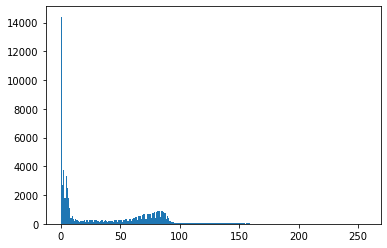

In [24]:
# Histogram
plt.hist(brain_im.ravel(), 256,[0,256])
plt.show()

# Threshold
def threshold(t1, t2, img):
    th_img = img.copy()
    th_img[th_img < t1] = 0
    th_img[th_img > t2] = 0
    th_img[(th_img >= t1) & (th_img <= t2)] = 1
    return th_img

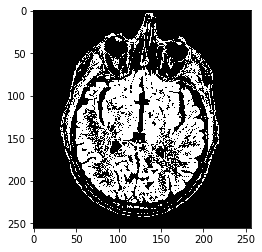

In [25]:
# apply threshold
th_img_wdg = threshold(55, 85, brain_im)
plt.imshow(th_img_wdg, cmap='gray')
plt.show()

Threshold for p1:  4.202872970184109 4.202872970184109
Threshold for p2:  44.87415534656914 104.87415534656914
0.355194091796875


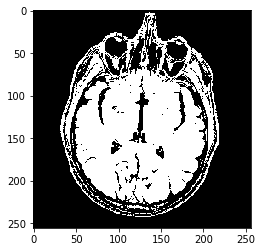

In [26]:
# Adaptive thresholding

# TODO: finish adaptive thresholding

# breaks image in region
# analyze every region alone and detect local static as threshold
def segmentation_img(img):
    seg_img = img.copy()
#     mean_val = seg_img.mean()
    mean_val = 30
    pixels_p1 = img[img<mean_val]
    pixels_p2 = img[img>=mean_val]
    
    p1th1 = pixels_p1.mean() - pixels_p1.min()
    p1th2 = pixels_p1.mean() + pixels_p1.min()
    print("Threshold for p1: ", p1th1, p1th2)
    th1 = threshold(p1th1, p1th2, pixels_p1)
    
    p2th1 = pixels_p2.mean() - pixels_p2.min()
    p2th2 = pixels_p2.mean() + pixels_p2.min()
    print("Threshold for p2: ", p2th1, p2th2)
    
    th2 = threshold(p2th1, p2th2, pixels_p2)
    seg_img[seg_img<mean_val] = th1
    seg_img[seg_img>=mean_val] = th2
    return seg_img
    

# should be done recursively and dinamically 
    
seg = segmentation_img(brain_im)
print(seg.mean())
plt.imshow(seg, cmap='gray')

array([71.30357143, 83.375     ])

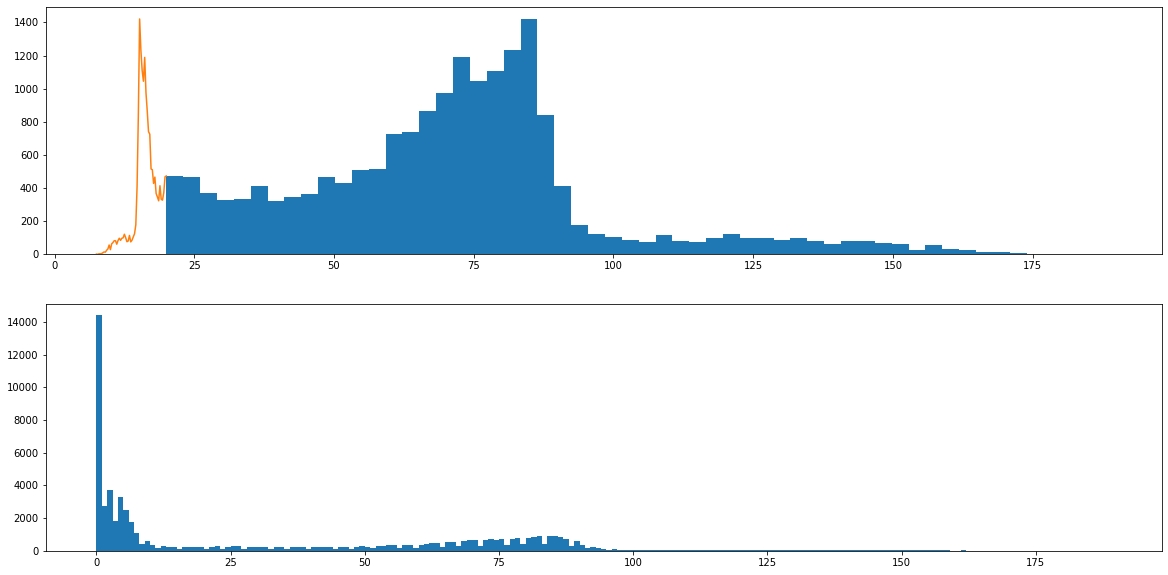

In [30]:
# Gaussian fitting histogram
import scipy
from scipy import ndimage
import numpy as np
gd = ndimage.gaussian_filter(brain_im, sigma=.1)
gx = ndimage.sobel(brain_im,axis=0,mode='constant')
gyx = ndimage.sobel(gx,axis=1,mode='constant')
data = brain_im.copy()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
#for better peak-valley ratio, kept only big gradient pixels
hsmooth = 3 #combine histogram bins to smooth histogram
Nb = int(round((max(data[gyx>100])-20)/hsmooth)) # number of bins
h = ax[0].hist(data[gyx>100].ravel(),bins = Nb, range = (20,max(data[gyx>100])));
ax[1].hist(data.ravel(),bins = max(data.ravel()));


ax[0].plot(np.linspace(start=20, stop=7.5, num=Nb),h[0])
peaks, _ = scipy.signal.find_peaks(h[0], height=1000)
h[1][peaks]

In [28]:
bins

NameError: name 'bins' is not defined

In [21]:
a = int(3.5)
a

3

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [9]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


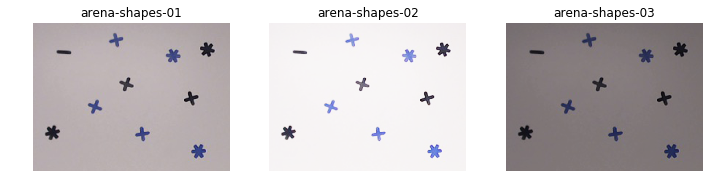

In [10]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion